# Model trials
- explores a bunch of clustering models
- stores each variation as a pickle file in the models folder

## what's in this notebook:
- load data
- kmeans & dbscan model trials
- filter for main dish recipes only
    - EDA on recipe tags
    - flag main dishes
    - match recipe ids in main-dish recipes to pre-processed version
- dummify main-dish recipes
- mysterious nulls in the "recipe_id" column
- kmeans with main-dish recipes only
- reduce number of ingredients/features
    - use most-frequently-occurring ingredients
    - use PCA to reduce features
- BIRCH clustering
- scipy dendrogram
- agglomerative clustering
- compare clustering models' performance
- cosine similarity
- get recommended alternatives

In [225]:
import importlib
import pickle
import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud

import modeling

In [39]:
importlib.reload(modeling);

## load data
- "ingr_dummies" is the dummified recipes with a row for each recipe and a column of 1/0 for each ingredient

In [2]:
flags_df = pd.read_parquet("data/generated_data/ingr_dummies.parquet")
flags_df.shape

(178265, 8023)

In [3]:
sample_flags = flags_df.sample(frac=0.25, replace=False)
sample_flags.shape

(44566, 8023)

---
## kmeans & dbscan model trials
- grid search is not readily useful here because there's no test data for it to use to evaluate one model against another
- I could write a custom scorer to use with grid search, for example it could use the silhouette score, but I had some trouble making that work when I tried it & in the end, this manual evaluation was good enough

In [5]:
kmeans_params = {
    "clusters": range(5, 31, 5),
    "max_iter": [300, 500]
}

dbscan_params = {
    "eps": [0.1, 0.25, 0.5, 1.0, 1.25],
    "algorithm": ["auto", "kd_tree"]
}

results = {}

In [7]:
kmeans_models = {}

for cluster in kmeans_params["clusters"]:
    for max_i in kmeans_params["max_iter"]:
        model_name = f"kmeans_{cluster}c_{max_i}i"
        details = {}
        details["clusters"] = cluster
        details["max_iter"] = max_i
        km = KMeans(n_clusters=cluster, max_iter=max_i, n_init="auto", random_state=42)
        km.fit(sample_flags)
        
        sil_score = silhouette_score(sample_flags, km.labels_)
        print(f"{model_name} score = {sil_score}")
        details["score"] = sil_score
        details["inertia"] = km.inertia_
        
        kmeans_models[model_name] = details
        
        with open(f"models/{model_name}.pkl", "wb") as f:
            pickle.dump(km, f)
        

kmeans_5c_300i score = 0.025359556961519467
kmeans_5c_500i score = 0.025359556961519467
kmeans_10c_300i score = 0.01024073806683298
kmeans_10c_500i score = 0.01024073806683298
kmeans_15c_300i score = 0.012603195125328414
kmeans_15c_500i score = 0.012603195125328414
kmeans_20c_300i score = 0.006635561539243761
kmeans_20c_500i score = 0.006635561539243761
kmeans_25c_300i score = 0.00571858492315883
kmeans_25c_500i score = 0.00571858492315883
kmeans_30c_300i score = 0.007765257017801726
kmeans_30c_500i score = 0.007765257017801726


In [8]:
dbscan_models = {}

for eps in dbscan_params["eps"]:
    for algo in dbscan_params["algorithm"]:
        model_name = f"dbscan_{eps}e_{algo}a"
        details = {}
        details["eps"] = eps
        details["algorithm"] = algo
        dbscan = DBSCAN(eps=eps, algorithm=algo, n_jobs=-1)
        dbscan.fit(sample_flags)
        
        sil_score = silhouette_score(sample_flags, dbscan.labels_)
        print(f"{model_name} score = {sil_score}")
        details["score"] = sil_score
        
        dbscan_models[model_name] = details
        
        with open(f"models/{model_name}", "wb") as f:
            pickle.dump(dbscan, f)

dbscan_0.1e_autoa score = -0.1137818994288678
dbscan_0.1e_kd_treea score = -0.1137818994288678
dbscan_0.25e_autoa score = -0.1137818994288678
dbscan_0.25e_kd_treea score = -0.1137818994288678
dbscan_0.5e_autoa score = -0.1137818994288678
dbscan_0.5e_kd_treea score = -0.1137818994288678
dbscan_1.0e_autoa score = -0.2008541704716405
dbscan_1.0e_kd_treea score = -0.2008541704716405
dbscan_1.25e_autoa score = -0.2008541704716405
dbscan_1.25e_kd_treea score = -0.2008541704716405


### more parameter tuning

In [9]:
for cluster in range(35, 101, 5):
    max_i = "default_"
    model_name = f"kmeans_{cluster}c_{max_i}i"
    details = {}
    details["clusters"] = cluster
    details["max_iter"] = max_i
    km = KMeans(n_clusters=cluster, n_init="auto", random_state=42)
    km.fit(sample_flags)
    
    sil_score = silhouette_score(sample_flags, km.labels_)
    print(f"{model_name} score = {sil_score}")
    details["score"] = sil_score
    details["inertia"] = km.inertia_
    
    kmeans_models[model_name] = details
    
    with open(f"models/{model_name}.pkl", "wb") as f:
        pickle.dump(km, f)

kmeans_35c_default_i score = 0.008281905915136617
kmeans_40c_default_i score = 0.007494932185157251
kmeans_45c_default_i score = 0.007244433685604815
kmeans_50c_default_i score = 0.0076677207469152
kmeans_55c_default_i score = 0.004070570047512586
kmeans_60c_default_i score = 0.005761999899310619
kmeans_65c_default_i score = 0.0065947546451767345
kmeans_70c_default_i score = 0.005518304051742554
kmeans_75c_default_i score = 0.0054834518212471895
kmeans_80c_default_i score = 0.005751633972537051
kmeans_85c_default_i score = 0.005776518868208993
kmeans_90c_default_i score = 0.005115344110135365
kmeans_95c_default_i score = 0.00500923247561521
kmeans_100c_default_i score = 0.005285331211656954


In [10]:
dbscan_eps = [0.0001, 0.001, 0.01]
powers = [2, 3]

for eps in dbscan_eps:
    for power in powers:
        model_name = f"dbscan_{eps}e_{power}p"
        details = {}
        details["eps"] = eps
        details["power"] = power
        dbscan = DBSCAN(eps=eps, p=power, n_jobs=-1)
        dbscan.fit(sample_flags)
        
        sil_score = silhouette_score(sample_flags, dbscan.labels_)
        print(f"{model_name} score = {sil_score}")
        details["score"] = sil_score
        
        dbscan_models[model_name] = details
        
        with open(f"models/{model_name}", "wb") as f:
            pickle.dump(dbscan, f)

dbscan_0.0001e_2p score = -0.1137818994288678
dbscan_0.0001e_3p score = -0.1137818994288678
dbscan_0.001e_2p score = -0.1137818994288678
dbscan_0.001e_3p score = -0.1137818994288678
dbscan_0.01e_2p score = -0.1137818994288678
dbscan_0.01e_3p score = -0.1137818994288678


----
## filter for main dish recipes only
- the full recipe database has all kinds of recipes so it's not too surprising that these models have been unimpressive
- let's see if filtering the recipes to just "main course" will improve the results

In [210]:
raw = pd.read_csv("data/kaggle_food_dot_com/RAW_recipes.csv")
raw.shape

(231637, 12)

In [211]:
raw.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [212]:
# reminder that this is a list wrapped in a string
raw["tags"][0]

"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']"

In [9]:
# regex for the win!!
re.findall(r"\b[\w+-?]+", raw["tags"][0])

['60-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'cuisine',
 'preparation',
 'occasion',
 'north-american',
 'side-dishes',
 'vegetables',
 'mexican',
 'easy',
 'fall',
 'holiday-event',
 'vegetarian',
 'winter',
 'dietary',
 'christmas',
 'seasonal',
 'squash']

In [213]:
def tags_to_list(tag_list):
    return re.findall(r"\b[\w+-?]+", tag_list)

raw["tag_list"] = raw["tags"].apply(tags_to_list)
raw["tag_list"].head()

0    [60-minutes-or-less, time-to-make, course, mai...
1    [30-minutes-or-less, time-to-make, course, mai...
2    [time-to-make, course, preparation, main-dish,...
3    [60-minutes-or-less, time-to-make, course, mai...
4    [weeknight, time-to-make, course, main-ingredi...
Name: tag_list, dtype: object

In [214]:
tags = raw["tag_list"].explode().unique()

# getting an error trying to write these tags to a file: TypeError: write() argument must be str, not float
# also need a `\n` between each element so the file is readable
tags = [ f"{tag}\n" for tag in tags if type(tag) == str]
len(tags)

560

### EDA on recipe tags

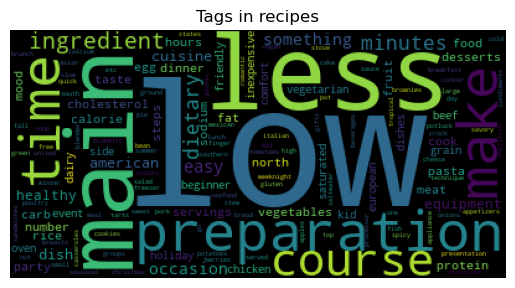

In [220]:
tag_block = " ".join([ tag for tag in raw["tag_list"].explode() if type(tag) == str ])

plt.imshow(WordCloud(collocations=False).generate(tag_block))
plt.axis("off")
plt.title(f"Tags in recipes");


In [221]:
raw.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'tag_list'],
      dtype='object')

In [222]:
def get_indredients(string_list):
    return re.findall(r"\b[\w\s]+", string_list)

raw["ingr_list"] = raw["ingredients"].apply(get_indredients)
raw["ingr_list"][0]

['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

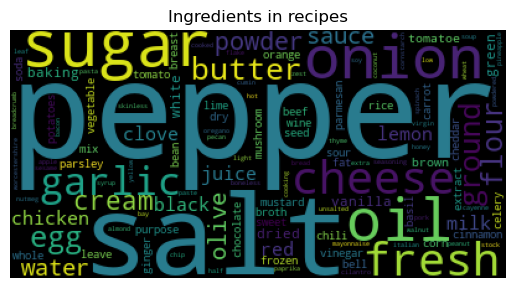

In [223]:
ingr_block = " ".join(raw["ingr_list"].explode())

plt.imshow(WordCloud(collocations=False).generate(ingr_block))
plt.axis("off")
plt.title(f"Ingredients in recipes");

In [13]:
# I need to get a good look at these tags so I know what to filter on
f = open("data/generated_data/tags.txt", "a")  # from https://www.w3schools.com/python/ref_file_writelines.asp
f.writelines(tags)
f.close()

In [14]:
# filtering for main course tags should include: ["*-main-dish-*", "main-dish", "dinner-party"] (searched tags for "main" and "dinner")
test_tags = ["middle-eastern-main-dish", "dinner-party", "main-dish-chicken", "pasta"]

for _ in test_tags:
    matches = re.search(r"main-dish|dinner", _)
    if matches != None:
        print(matches)

<re.Match object; span=(15, 24), match='main-dish'>
<re.Match object; span=(0, 6), match='dinner'>
<re.Match object; span=(0, 9), match='main-dish'>


### flag main dishes

In [15]:
def flag_main(tag_list):
    matches = re.search(r"main-dish|dinner", " ".join(tag_list))
    return 1 if matches != None else 0

raw["main_course"] = raw["tag_list"].apply(flag_main)

In [16]:
sum(raw["main_course"])

96201

In [17]:
mains = raw.loc[raw["main_course"] == 1]
mains.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,tag_list,main_course
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,"[30-minutes-or-less, time-to-make, course, mai...",1
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,"[time-to-make, course, preparation, main-dish,...",1
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,"[60-minutes-or-less, time-to-make, course, mai...",1
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,"[15-minutes-or-less, time-to-make, course, mai...",1
7,backyard style barbecued ribs,67888,120,10404,2003-07-30,"['weeknight', 'time-to-make', 'course', 'main-...","[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]",10,['in a medium saucepan combine all the ingredi...,this recipe is posted by request and was origi...,"['pork spareribs', 'soy sauce', 'fresh garlic'...",22,"[weeknight, time-to-make, course, main-ingredi...",1


In [18]:
main_course_ids = list(mains["id"])
len(main_course_ids)

96201

In [19]:
type(main_course_ids[0])

int

### match recipe ids in main-dish recipes to pre-processed version

In [20]:
proc_df = pd.read_parquet("data/generated_data/processed_recipes.parquet")
proc_df.head(3)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,ingr_ints
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]","[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...","[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...","[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."


In [21]:
type(proc_df["id"][0])

numpy.int64

In [22]:
proc_mains = proc_df.loc[proc_df["id"].isin(main_course_ids)]

In [23]:
proc_mains.shape

(75297, 9)

In [24]:
ingredients = proc_mains["ingr_ints"].explode().unique()
len(ingredients)

6863

## dummify main-dish recipes
- main course has 6,863 ingredients; the "ingr_map" has 8,023 ingredients, seems reasonable that this filtered list would have about 85% of those

In [25]:
cols = []
for id_col in ingredients:
    col = []
    for recipe_row in range(0, proc_mains.shape[0]):
        flag = 1 if id_col in proc_mains["ingr_ints"].iloc[recipe_row] else 0
        col.append(flag)
    cols.append(pd.Series(col))
    
flag_proc_df = pd.concat(cols, axis=1)
flag_proc_df.shape

(75297, 6863)

- I need to keep the recipe id with the flagged data

In [26]:
flag_proc_df["recipe_id"] = proc_mains["id"]

In [27]:
file_name = "data/generated_data/main_dish_dummies.parquet"
flag_proc_df.to_parquet(file_name, engine="pyarrow", compression="gzip")

/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


---
## mysterious nulls in the "recipe_id" column

In [29]:
flag_proc_df["recipe_id"].isna().sum()

43339

- huh?

In [31]:
proc_mains.shape[0] == flag_proc_df.shape[0]

True

In [42]:
proc_mains["id"].isna().sum()

0

- there are no nulls in the un-dummified data and 43,339 (57%!) nulls in the dummified data

In [56]:
# I don't know why adding that column in a normal way is giving me nulls but I don't have time to figure it out
for idx in range(proc_mains.shape[0]):
    flag_proc_df.iloc[idx]["recipe_id"] = proc_mains.iloc[idx]["id"]

/var/folders/sm/pxzljrp530ddx9cxpl80jslh0000gn/T/ipykernel_47478/3445753008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_proc_df.iloc[idx]["recipe_id"] = proc_mains.iloc[idx]["id"]


In [57]:
flag_proc_df["recipe_id"].isna().sum()

43339

- yup, still all those nulls

In [62]:
suspect_ids = [ f"{id}\n" for id in flag_proc_df["recipe_id"] ]
f = open("data/generated_data/ids.txt", "a")  # from https://www.w3schools.com/python/ref_file_writelines.asp
f.writelines(suspect_ids)
f.close()

In [63]:
orig_ids = [ f"{id}\n" for id in proc_mains["id"] ]
f = open("data/generated_data/orig_ids.txt", "a")
f.writelines(orig_ids)
f.close()

- okay I still don't know why this is happening but those two files are...interesting

In [64]:
flag_proc_df["recipe_id"] = [int(id) for id in proc_mains["id"]]
flag_proc_df["recipe_id"].isna().sum()

0

- I'm sure there's some dumb pandas reason why I had to do it that way

In [66]:
file_name = "data/generated_data/main_dish_dummies.parquet"
flag_proc_df.to_parquet(file_name, engine="pyarrow", compression="gzip")

/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


- this warning is actually about the COLUMN names and not the row types but I'm glad it came up earlier because I hadn't even thought to check for nulls in those recipe ids

---
## kmeans with main-dish recipes only
- please be better, please be better, please be better

In [78]:
new_model_details = pd.DataFrame()

kmeans_mains = modeling.try_kmeans_models(cluster_range=range(5, 50, 7), name_modifier="all_mains", 
                                          data_df=flag_proc_df.drop(columns=["recipe_id"]), models_df=new_model_details)

kmeans_5c_mains_all_mains score = 0.02611545207525439
kmeans_12c_mains_all_mains score = 0.014283476656228896
kmeans_19c_mains_all_mains score = 0.012512314175224897
kmeans_26c_mains_all_mains score = 0.008327280580775554
kmeans_33c_mains_all_mains score = 0.008020459279035021
kmeans_40c_mains_all_mains score = 0.006950586773818742
kmeans_47c_mains_all_mains score = 0.005277396017073416


In [79]:
kmeans_mains

,model_type,clusters,score,inertia,name
0,kmeans,5,0.026115,636096.272441,kmeans_5c_mains_all_mains
1,kmeans,12,0.014283,607286.457808,kmeans_12c_mains_all_mains
2,kmeans,19,0.012512,593800.245345,kmeans_19c_mains_all_mains
3,kmeans,26,0.008327,585401.726760,kmeans_26c_mains_all_mains
4,kmeans,33,0.008020,579045.612712,kmeans_33c_mains_all_mains
5,kmeans,40,0.006951,574295.436875,kmeans_40c_mains_all_mains
6,kmeans,47,0.005277,568123.103745,kmeans_47c_mains_all_mains


In [36]:
dbscan_eps = [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 1.25]
dbscan_model_details = []

for eps in dbscan_eps:
    trial_details = {}
    trial_details["eps"] = eps
    dbscan = DBSCAN(eps=eps, n_jobs=-1)
    dbscan.fit(flag_proc_df)
    
    sil_score = silhouette_score(flag_proc_df, dbscan.labels_)
    trial_details["score"] = sil_score
    
    dbscan_model_details.append(trial_details)
    
    model_name = f"dbscan_{eps}e_mains"
    print(f"{model_name} score = {sil_score}")
    
    with open(f"models/main_course_recipes_models/{model_name}", "wb") as f:
        pickle.dump(dbscan, f)

dbscan_0.0001e_mains score = -0.11207505922147183
dbscan_0.001e_mains score = -0.11207505922147183
dbscan_0.01e_mains score = -0.11207505922147183
dbscan_0.1e_mains score = -0.11207505922147183
dbscan_0.25e_mains score = -0.11207505922147183
dbscan_0.5e_mains score = -0.11207505922147183
dbscan_1.0e_mains score = -0.18771775409269265
dbscan_1.25e_mains score = -0.18771775409269265


---
## reduce number of ingredients/features
- maybe 6,863 ingredients is too many
- let's try with fewer ingredients

In [2]:
flag_proc_df = pd.read_parquet("data/generated_data/main_dish_dummies.parquet")
flag_proc_df.shape

(75297, 6863)

### use most-frequently-occurring ingredients

In [71]:
# use only ingredients that show up in more than 5 recipes from: https://www.geeksforgeeks.org/pandas-filter-a-dataframe-by-the-sum-of-rows-or-columns/
df = flag_proc_df.loc[:, flag_proc_df.sum(axis=0) > 5]  # that 5 is totally arbitrary

In [80]:
df.shape

(75297, 3526)

In [82]:
updated_kmeans_results = modeling.try_kmeans_models(cluster_range=range(5,50,7), name_modifier="half_features", 
                                                    data_df=df.drop(columns=["recipe_id"]), models_df=kmeans_mains)

kmeans_5c_mains_half_features score = 0.029910841250235503
kmeans_12c_mains_half_features score = 0.013916367465081743
kmeans_19c_mains_half_features score = 0.010370923066061931
kmeans_26c_mains_half_features score = 0.003903981046639545
kmeans_33c_mains_half_features score = 0.005742282437713488
kmeans_40c_mains_half_features score = 0.0016878940560285907
kmeans_47c_mains_half_features score = 0.0035814081637385695


- that was no better than the results of all the main dishes
- I also don't know why my `range(5,55,7)` was stepping by 5 instead of 7?? 
    - figure out that it was because I hadn't reimported modeling.py after changing the loop in that function from the hard-coded range

### use PCA to reduce features
- instead of me deciding how many features to include, let's let sklearn actually figure out what's important
- this is from lesson 2.23

In [23]:
# per docs, "randomized" solver is used for input data larger than 500x500, 
#  I'm specifying it here so I remember that later
#  first ran this cell when df did not include the recipe_id column
pca = PCA(svd_solver="randomized", random_state=42)
pca.fit(df)
trained = pca.transform(df)

In [25]:
# Pull the explained variance attribute.
# shows how much of the variance is explained by each PCA, these values will always add up to 1
var_exp = pca.explained_variance_ratio_
print(f"Explained variance (first 20 components): {np.round(var_exp[:20], 3)}\n")

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 30 components): {np.round(cum_var_exp[:30], 3)}') 

Explained variance (first 20 components): [0.034 0.031 0.025 0.021 0.018 0.015 0.014 0.013 0.012 0.011 0.011 0.01
 0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.007]

Cumulative explained variance (first 30 components): [0.034 0.065 0.09  0.111 0.129 0.144 0.159 0.172 0.184 0.195 0.206 0.216
 0.225 0.235 0.244 0.252 0.261 0.268 0.276 0.283 0.291 0.298 0.304 0.311
 0.317 0.324 0.33  0.336 0.341 0.346]


In [33]:
# how many features do I want to include? found this at: https://www.geeksforgeeks.org/python-get-the-index-of-first-element-greater-than-k/
i_90 = next(x for x, val in enumerate(cum_var_exp)if val > 0.9)
print(f"the first {i_90-1} features out of {len(cum_var_exp)} explain 90% of the variance")

the first 827 features out of 3525 explain 90% of the variance


In [84]:
pca_90 = PCA(svd_solver="randomized", random_state=42, n_components=827)
pca_90.fit(df.drop(columns=["recipe_id"]))
trained = pca_90.transform(df.drop(columns=["recipe_id"]))

In [85]:
pca_kmeans_results = modeling.try_kmeans_models(cluster_range=range(5, 20, 7), name_modifier="pca_90", 
                                                data_df=trained, models_df=updated_kmeans_results)

kmeans_5c_mains_pca_90 score = 0.026829644684107607
kmeans_12c_mains_pca_90 score = 0.011722777805553905
kmeans_19c_mains_pca_90 score = 0.004633226682016011


In [90]:
pca_kmeans_results["name"]

0         kmeans_5c_mains_all_mains
1        kmeans_12c_mains_all_mains
2        kmeans_19c_mains_all_mains
3        kmeans_26c_mains_all_mains
4        kmeans_33c_mains_all_mains
5        kmeans_40c_mains_all_mains
6        kmeans_47c_mains_all_mains
0     kmeans_5c_mains_half_features
1    kmeans_12c_mains_half_features
2    kmeans_19c_mains_half_features
3    kmeans_26c_mains_half_features
4    kmeans_33c_mains_half_features
5    kmeans_40c_mains_half_features
6    kmeans_47c_mains_half_features
0            kmeans_5c_mains_pca_90
1           kmeans_12c_mains_pca_90
2           kmeans_19c_mains_pca_90
Name: name, dtype: object

---
## BIRCH clustering
- BIRCH is another hierarchical clustering model
- BIRCH = balanced iterative reducing and clustering using hierarchies
- reference [this article](https://medium.com/@meaabarquez/clustering-101-understanding-birch-clustering-using-jupyter-notebook-python-b28f47ae7c68)

In [3]:
# getting data after kernel crashed
flag_proc_df = pd.read_parquet("data/generated_data/main_dish_dummies.parquet")
flag_proc_df.shape

(75297, 6864)

In [4]:
"recipe_id" in flag_proc_df.columns

True

In [5]:
sampled = flag_proc_df.sample(frac=0.3)

# we'll try this on the sampled df, maybe it won't crash
pca_90 = PCA(svd_solver="randomized", random_state=42, n_components=827)
pca_90.fit(sampled.drop(columns=["recipe_id"]))
trained = pca_90.transform(sampled.drop(columns=["recipe_id"]))
trained.shape

(22589, 827)

---
## scipy dendrogram
- maybe there's a better way to figure out how many clusters than me picking numbers at random to see what works

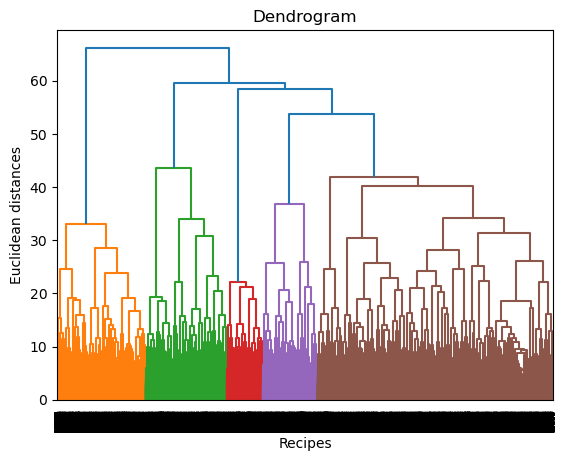

In [6]:
# saw this here: https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318
#  & thought I'd give it a try
dendrogram = sch.dendrogram(sch.linkage(trained, method  = "ward"))
plt.title("Dendrogram")
plt.xlabel("Recipes")
plt.ylabel("Euclidean distances")
plt.show();

In [7]:
# let's trust the tree
brc = Birch(n_clusters=5)
brc.fit(trained)

Birch(n_clusters=5)

In [22]:
brc_5_score = silhouette_score(trained, brc.labels_)
brc_5_score

0.008339590437463813

In [9]:
# okay, let's not trust the tree
# 3 clusters is the default
brc_3 = Birch(n_clusters=3)
brc_3.fit(trained)
# silhouette_score(trained, brc_3.labels_)

0.01550135742053126

In [21]:
brc_3_score = silhouette_score(trained, brc_3.labels_)
brc_3_score

0.01550135742053126

---
## agglomerative clustering
- suggestion from Sumit to use hierarchical clustering

In [12]:
# starting with all default values & fitting on the sampled, PCA transformed set of features
agg_c = AgglomerativeClustering()
agg_c.fit(trained)

AgglomerativeClustering()

- [the article](https://towardsdatascience.com/a-practical-introduction-to-hierarchical-clustering-from-scikit-learn-ffaf8ee2670c) I read about AgglomerativeClustering says that you can't use the silhouette score to evaluate the model
- according to that article, you'd have to rely on your domain knowledge to say if the model is generating anything useful
- I'm going to calculate it anyway

In [18]:
agg_default = silhouette_score(trained, agg_c.labels_)
agg_default

0.018914522460410203

In [14]:
pd.Series(agg_c.labels_).unique()

array([0, 1])

In [15]:
agg_c_5 = AgglomerativeClustering(n_clusters=5)
agg_c_5.fit(trained)

AgglomerativeClustering(n_clusters=5)

In [19]:
agg_5 = silhouette_score(trained, agg_c_5.labels_)
agg_5

0.0036272710213365294

In [17]:
prev_model_details = pd.read_parquet("data/generated_data/filtered_kmeans_model_trials.parquet")
prev_model_details.columns

Index(['model_type', 'clusters', 'score', 'inertia', 'name'], dtype='object')

In [23]:
latest_details = [
    {
        "model_type": "birch clustering",
        "clusters": 3,
        "score": brc_3_score,
        "inertia": 0.0,
        "name": "not saved"
    },
    {
        "model_type": "birch clustering",
        "clusters": 5,
        "score": brc_5_score,
        "inertia": 0.0,
        "name": "not saved"
    },
    {
        "model_type": "agglomerative clustering",
        "clusters": 2,
        "score": agg_default,
        "inertia": 0.0,
        "name": "not saved"
    },
    {
        "model_type": "agglomerative clustering",
        "clusters": 5,
        "score": agg_5,
        "inertia": 0.0,
        "name": "not saved"
    }
]

updated_data = pd.concat([prev_model_details, pd.DataFrame.from_dict(latest_details)], ignore_index=True)
updated_data.shape

(21, 5)

In [24]:
updated_data.to_parquet("data/generated_data/filtered_kmeans_model_trials.parquet", engine="pyarrow", compression="gzip")

In [26]:
type(trained)

numpy.ndarray

---
## compare clustering models' performance

In [224]:
perf = pd.read_parquet("data/generated_data/model_trial_details.parquet")
perf.head()

,model_type,clusters,score,inertia,name
0,kmeans,5,0.026115,636096.272441,kmeans_5c_mains_all_mains
1,kmeans,12,0.014283,607286.457808,kmeans_12c_mains_all_mains
2,kmeans,19,0.012512,593800.245345,kmeans_19c_mains_all_mains
3,kmeans,26,0.008327,585401.726760,kmeans_26c_mains_all_mains
4,kmeans,33,0.008020,579045.612712,kmeans_33c_mains_all_mains


In [226]:
perf["model_type"].value_counts()

model_type
kmeans                      17
birch clustering             2
agglomerative clustering     2
Name: count, dtype: int64

In [227]:
perf["clusters"].value_counts()

clusters
5     5
12    3
19    3
26    2
33    2
40    2
47    2
3     1
2     1
Name: count, dtype: int64

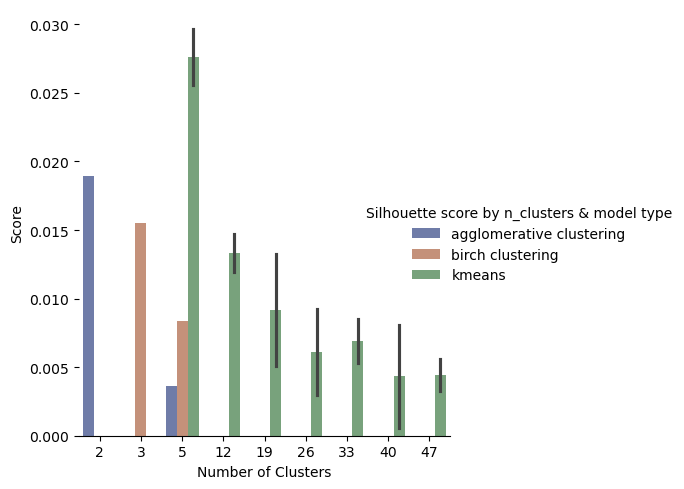

In [231]:
bars = sns.catplot(
    data=perf, kind="bar",
    x="clusters", y="score", hue="model_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("Number of Clusters", "Score")
# plt.xticks(rotation=90)
bars.legend.set_title("Silhouette score by n_clusters & model type");

---
## cosine similarity
- another idea from Sumit
- based on lesson 2.25, which builds a recommender system based on movie reviews, where we have movie titles, user ids & ratings
- I think the analogs in my data are:
    - user ids = recipe ids --> not every recipe will have every ingredient, just as not every user will rate every movie
    - movie titles = ingredients --> one ingredient can be in lots of recipes, just as the same movie will be rated by multiple users
    - ratings = 1/0 for the presence or absence of that ingredient?
- will work on this idea with 40% of the data to start

In [33]:
map_df = pd.read_pickle("data/kaggle_food_dot_com/ingr_map.pkl")

In [49]:
# the plan was to map the ingredient lists from multiple recipes at once, so the function wants a list of lists
#   and it returns a list of lists
food_stops = [["salt", "black pepper", "water", "olive oil", "butter", "oil"]]
codes = modeling.map_recipe_ingredients(pd.Series(food_stops), map_df)[0]

In [50]:
codes

[6270, 590, 7655, 5006, 840, 4987]

In [46]:
map_df.loc[map_df["id"] == 6270]

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
902,aunt jane's krazy mixed up salt,6,salt,4,salt,72848,6270
903,low sodium salt,3,salt,4,salt,72848,6270
904,salt,1,salt,4,salt,72848,6270


In [52]:
mains = pd.read_parquet("data/generated_data/main_dish_dummies.parquet")
sample_40 = mains.sample(frac=0.4)

In [53]:
# let's drop these columns from the sampled data
#  got a KeyError when I tried to drop code 7655 (water) so I listed them manually
sample_40.drop(columns=[ "6270", "590", "5006", "840", "4987"], axis=1, inplace=True)
sample_40.shape

(30119, 6859)

In [54]:
# now to get rid of ingredients that appear in less than 10% of the recipes
df = sample_40.loc[:, sample_40.sum(axis=0) > 301]  # that 10% is still arbitrary

In [55]:
df.shape

(30119, 172)

In [56]:
# checking to see if we have any recipes for which all the ingredients were dropped in the last step
# from that same post as earlier: https://www.geeksforgeeks.org/pandas-filter-a-dataframe-by-the-sum-of-rows-or-columns/
df = df[df.drop(columns=["recipe_id"]).sum(axis=1) > 0] 
df.shape

(29786, 172)

In [57]:
[ index for index, value in enumerate(list(df.iloc[0])) if value == 1]

[6, 7, 13, 15, 18, 58, 88, 111, 120, 134]

In [58]:
def make_rows(df: pd.DataFrame, num_rows: int) -> pd.DataFrame:
    df_columns = df.columns
    rows = []
    for i in range(num_rows):
        row_data = list(df.iloc[i])
        recipe_id = row_data[0]
        for ingr in [ index for index, value in enumerate(list(df.iloc[i])) if value == 1]:
            data_dict = {}
            data_dict["recipe_id"] = recipe_id
            data_dict["ingredient"] = df_columns[ingr]
            data_dict["in_recipe"] = 1
            rows.append(data_dict)
    
    return pd.DataFrame.from_dict(rows)

In [59]:
adj_df = make_rows(df, df.shape[0])
adj_df.shape

(192706, 3)

In [60]:
adj_df.head()

,recipe_id,ingredient,in_recipe
0,17962,10,1
1,17962,11,1
2,17962,23,1
3,17962,26,1
4,17962,29,1


In [61]:
pivot = pd.pivot_table(adj_df, index="ingredient", columns="recipe_id", values="in_recipe")
pivot.head()

recipe_id,112,181,245,289,361,422,467,472,493,517,...,531255,532075,532629,534760,535319,535320,536011,536051,536318,537039
ingredient,,,,,,,,,,,,,,,,,,,,,
10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0
1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [62]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
sys.getsizeof(sparse_pivot)

48

In [63]:
recommender = cosine_similarity(sparse_pivot)

In [64]:
rec_df = pd.DataFrame(recommender, columns=pivot.index, index=pivot.index)
rec_df.head()

ingredient,10,101,1015,102,103,104,106,11,110,112,...,84,89,9,90,94,95,97,98,99,998
ingredient,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.266726,0.057712,0.074069,0.162367,0.104770,0.165997,0.499387,0.030145,0.086810,...,0.079507,0.169325,0.271916,0.103948,0.166908,0.072712,0.167370,0.076115,0.126599,0.066563
101,0.266726,1.000000,0.033912,0.038595,0.086688,0.065697,0.065789,0.007827,0.027393,0.041857,...,0.038150,0.073490,0.077926,0.033658,0.084155,0.033637,0.062590,0.048016,0.037823,0.041471
1015,0.057712,0.033912,1.000000,0.029814,0.014693,0.001993,0.028006,0.043037,0.004382,0.020086,...,0.002397,0.008289,0.041134,0.005922,0.015058,0.000000,0.003260,0.003017,0.008094,0.028804
102,0.074069,0.038595,0.029814,1.000000,0.046467,0.011231,0.045089,0.073445,0.021164,0.027487,...,0.000000,0.005338,0.073196,0.007151,0.048487,0.028076,0.048118,0.009716,0.010859,0.018550
103,0.162367,0.086688,0.014693,0.046467,1.000000,0.063029,0.036189,0.099807,0.058111,0.060789,...,0.069294,0.062575,0.058895,0.026180,0.099425,0.030189,0.115306,0.050276,0.055965,0.034282


In [34]:
map_df.columns

Index(['raw_ingr', 'raw_words', 'processed', 'len_proc', 'replaced', 'count',
       'id'],
      dtype='object')

In [43]:
map_df.loc[map_df["id"] == 1015, "raw_ingr"]

4809    canned red beans
Name: raw_ingr, dtype: object

## get recommended alternatives

In [74]:
# copied this directly from lesson 2.25
search = 1015  # I can see from the above that this id is in the pivot table

for food in map_df.loc[map_df["id"] == search, "raw_ingr"]:
    print(food)
    print(f"appears in {pivot.T[str(search)].count()} recipes")
    print("")
    print("10 closest codes")
    closest = rec_df[str(search)].sort_values(ascending = False)[1:11]
    print(closest)
    print("")
    print("*******************************************************************************************")
    print("")

canned red beans
appears in 324 recipes

10 closest codes
ingredient
278    0.110141
59     0.095920
29     0.094621
23     0.092459
243    0.089403
133    0.077625
172    0.068886
72     0.066861
28     0.064089
233    0.061202
Name: 1015, dtype: float64

*******************************************************************************************



In [100]:
top_hits = rec_df[str(search)].sort_values(ascending = False)[1:11]

ingreds = []
for i in top_hits:
    # get str index where the search ingredient matches the value in top_hits
    #  that index = the ingredient id
    ingr_id = rec_df.index[rec_df[str(search)]==i].array[0]
    mapped = map_df.loc[map_df["id"] == int(ingr_id), "raw_ingr"]
    ingreds.append(list(mapped)[0])
    
ingreds

['baby lima beans',
 'pillsbury best all purpose flour',
 'adobo seasoning',
 'aceto balsamico',
 'miniature party rye rounds',
 'angelica',
 'apricot baby food',
 'almond brickle chips',
 'adobo sauce',
 'miniature semisweet chocolate chips']

In [99]:
for hit in ingreds:
    print(list(hit)[0])

baby lima beans
pillsbury best all purpose flour
adobo seasoning
aceto balsamico
miniature party rye rounds
angelica
apricot baby food
almond brickle chips
adobo sauce
miniature semisweet chocolate chips


In [49]:
map_df.loc[map_df["id"] == 278, "raw_ingr"]

5581    baby lima beans
Name: raw_ingr, dtype: object

In [50]:
map_df.loc[map_df["id"] == 243, "raw_ingr"]

2897    miniature party rye rounds
Name: raw_ingr, dtype: object

In [51]:
map_df.loc[map_df["id"] == 23, "raw_ingr"]

7084    aceto balsamico
Name: raw_ingr, dtype: object

In [122]:
rec_df.to_parquet("data/generated_data/recommender_sample.parquet", engine="pyarrow", compression="gzip")

In [124]:
pivot.to_parquet("data/generated_data/pivot_sample.parquet", engine="pyarrow", compression="gzip")

---
## recommender for all mains?

In [148]:
mains.drop(columns=[ "6270", "590", "5006", "840", "4987"], axis=1, inplace=True)

KeyError: "['6270', '590', '5006', '840', '4987'] not found in axis"

In [149]:
mains.shape

(75297, 6859)

In [111]:
# getting rid of ingredients that are in only a handful of recipes
# tried a few different thresholds for this and picked one that left me with > 200 ingredients
# that threshold is still arbitrary
df_all = mains.loc[:, mains.sum(axis=0) > 500]
df_all.shape

(75297, 247)

In [112]:
df_all = df_all[df_all.drop(columns=["recipe_id"]).sum(axis=1) > 0]
df_all.shape

(74792, 247)

In [150]:
pre_pivot = make_rows(mains, mains.shape[0])
pre_pivot.shape

(724925, 3)

In [151]:
pre_pivot.head(3)

,recipe_id,ingredient,in_recipe
0,74301,0,1
1,74301,1,1
2,74301,2,1


In [152]:
pivot_all = pd.pivot_table(pre_pivot, index="ingredient", columns="recipe_id", values="in_recipe")

In [153]:
sparse_pivot_all = sparse.csr_matrix(pivot_all.fillna(0))
sys.getsizeof(sparse_pivot_all)

48

In [154]:
rec_all = cosine_similarity(sparse_pivot_all)

In [155]:
rec_all_df = pd.DataFrame(rec_all, columns=pivot_all.index, index=pivot_all.index)
rec_all_df.head()

ingredient,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
ingredient,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.009413,0.015666,0.004601,0.036811,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.008372,0.000000,0.000000,0.000000,0.000000
1,0.009413,1.000000,0.039192,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008402,0.000000
10,0.015666,0.039192,1.000000,0.048764,0.000000,0.023386,0.00555,0.004111,0.012222,0.035241,...,0.005147,0.002305,0.002068,0.0,0.014042,0.027654,0.022748,0.014536,0.075305,0.000000
100,0.004601,0.000000,0.048764,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.003410,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.021179,0.000000,0.019713,0.000000
1000,0.036811,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.182574


In [156]:
search = 1015

In [157]:
for food in map_df.loc[map_df["id"] == search, "raw_ingr"]:
    print(food)
    print(f"appears in {pivot_all.T[str(search)].count()} recipes")
    print("")
    print("10 closest codes")
    closest = rec_all_df[str(search)].sort_values(ascending = False)[1:11]
    print(closest)
    print("")
    print("*******************************************************************************************")
    print("")

canned red beans
appears in 845 recipes

10 closest codes
ingredient
243    0.109731
278    0.109439
577    0.100342
59     0.098889
29     0.098758
23     0.095386
133    0.077858
172    0.073211
72     0.064800
28     0.063751
Name: 1015, dtype: float64

*******************************************************************************************



In [158]:
codes = []
for label in ["olives"]:
# for label in ["plum tomatoes"]:
    replaced = map_df.loc[map_df["replaced"] == label.lower()]
    raw = map_df.loc[map_df["raw_ingr"].str.find(label.lower()) != -1]
    if replaced.shape[0] > 0:
        print(f"found {label} in replaced")
        code = replaced["id"].value_counts().idxmax()
        
    elif raw.shape[0] > 0:
        print(f"found {label} in raw")
        code = raw["id"].value_counts().idxmax()
        
    else:
        print(f"couldn't find {label}")
        code=-1
    
    codes.append(code)

found olives in raw


In [159]:
codes

[6719]

In [164]:
search = 6719

top_hits = rec_all_df[str(search)].sort_values(ascending = False)[1:11]

ingreds = []
for i in top_hits:
    # get str index where the search ingredient matches the value in top_hits
    #  that index = the ingredient id
    ingr_id = rec_all_df.index[rec_all_df[str(search)]==i].array[0]
    mapped = map_df.loc[map_df["id"] == int(ingr_id), "raw_ingr"]
    ingreds.append(list(mapped)[0])
    
ingreds

['canned mushroom slices',
 'canned white beans',
 'sodium-free beef bouillon',
 'au jus mix',
 "hershey's semi-sweet baking chocolate",
 "hershey's semi-sweet baking chocolate",
 "hershey's semi-sweet baking chocolate",
 "hershey's semi-sweet baking chocolate",
 "hershey's semi-sweet baking chocolate",
 "hershey's semi-sweet baking chocolate"]

In [165]:
rec_all_df.to_parquet("data/generated_data/recommender_all.parquet", engine="pyarrow", compression="gzip")

---
## code for app

In [166]:
def find_ingredient_id(ingred: str) -> set[str]:
    """ 
    finds ids in "ingr_map" data that matches selected ingredient, searching in the
    "replaced" and "raw_ingr" columns
    Args:
        ingred: the ingredient to search for
    Returns: int id that seems like the closest match for the ingredient
    """
    codes = []
    replaced = map_df.loc[map_df["replaced"] == ingred.lower()]
    raw = map_df.loc[map_df["raw_ingr"].str.find(ingred.lower()) != -1]
    if replaced.shape[0] > 0:
        # code = replaced["id"].value_counts().idxmax()
        codes.extend(replaced["id"])
        
    elif raw.shape[0] > 0:
        # code = raw["id"].value_counts().idxmax()
        codes.extend(raw["id"])
        
    else:
        print(f"couldn't find {ingred}")
        # return empty set
        return set(codes)
    
    return set([ str(code) for code in codes ])

In [170]:
onion = find_ingredient_id("onion")
olives = find_ingredient_id("olives")

In [206]:
def recommend_subs(codes: list[str]) -> list[str]:
    # build dict of ingredient labels & their values from the recommender
    hits = {}
    for code in codes:
        # just in case the ingredient is one those we removed because of its infrequency
        if code in list(rec_all_df.columns):
            # get top 10 values from the rec_all_df
            top_hits = rec_all_df[code].sort_values(ascending = False)[1:11]
            for i in top_hits:
                # get str index where the search ingredient matches the value in top_hits
                #  that index = the ingredient id
                ingr_id = rec_all_df.index[rec_all_df[code]==i].array[0]
                mapped = map_df.loc[map_df["id"] == int(ingr_id), "raw_ingr"]
                ing_label = list(mapped)[0]
                # if that label is already in the dict, keep it set to the highest value from recommender
                if ing_label in hits.keys():
                    prev_value = hits[ing_label]
                    value = i if i > prev_value else prev_value
                    hits[ing_label] = value
                else:
                    hits[ing_label] = i
    
    if len(hits) > 0:
        return sorted(hits.items(), key=lambda x: x[1], reverse=True)
        # print(hits)
        # return hits
    else:
        return []

In [207]:
onion_subs = recommend_subs(onion)

In [208]:
onion_subs

[('parkay margarine', 0.35355339059327373),
 ('horseradish root', 0.2357022603955158),
 ('egg yolk', 0.12309149097933274),
 ('chocolate-covered pretzels', 0.07372097807744857),
 ('blended oatmeal', 0.04295367795875577),
 ('besan flour', 0.03641785203646149),
 ('canned white beans', 0.0363216356146074),
 ('any desired food coloring', 0.03566881875032108),
 ('alfalfa sprout', 0.029800997754107487),
 ('7-up soda', 0.02312795668267286)]